<br > **AmirMahdi Zeighami**
<br > **401301316**

<p style="text-align:right;">گزارش کلی این سوال : 
<br > کدهای این سوال با استفاده از نمونه خود تورچ زده شده است. ابتدا دیکشنری از تمامی کلمات دیتاست ساخته می شود و سپس یک ایندکس به هر دیتا نسبت داده می شود که همان توکن است. ساختار خواسته شده پیاده سازی شده است و سپس آموزش داده می شود. تیچر فورسینک هم اعمال شده است. با اعمال 500 مصرع، مقدار خطای مدل با توجه به مصرع های دوم هر بیت و دقت آن محاسبه می گردد. در نهایت نمودار ها رسم می شود. هم چنین ساختار های شبکه برای هر دو شبکه مورد نظر در سوال آموزش داده شده است و نتایج به تبع آن نمایش داده شده اند. در نهایت شبکه جی آر یو از ال اس تی ام دقت بهتر و خسارت کمتر در شرایط برابر داشت. متاسفانه با توجه به کمبود وقت امکان اجرای ایپاک های بیشتر میسر نبود


In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torchtext.data.metrics import bleu_score
import torch.nn.functional as F
from torchtext.data.metrics import bleu_score
from tqdm import tqdm
!pip install gdown
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


In [2]:
!gdown 1QuLf2QV0lrajg32SFpHwFXPQXf7ieVBh

Downloading...
From: https://drive.google.com/uc?id=1QuLf2QV0lrajg32SFpHwFXPQXf7ieVBh
To: /content/ferdousi.txt
100% 4.54M/4.54M [00:00<00:00, 20.5MB/s]


Data Preprocessing

در این بخش در ابتدا فایل خوانده شده است و هر خط که یک مصرع است در یک لیست ذخیره می شود

In [3]:
lines = open('ferdousi.txt', encoding='utf-8').\
        read().strip().split('\n')

lines = lines[2:-1]

In [4]:
lines[1]

'کزین برتر اندیشه برنگذرد'

ترکیبات دوتایی که هر ترکیب دو مصرع یک شعر است در یک آرایه نامپای ذخیره می‌شود

In [5]:
pairs = []
for i in range(int(len(lines)/2)):
    thisPair = [lines[i*2], lines[i*2+1]]
    pairs.append(thisPair)

دیکشنری از تمام کلمات همه ی ابیات ساخته می شود

In [82]:
SOS_token = 0
EOS_token = 1
maxLength = 15
class myDict:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words+1] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [83]:
dictionary = myDict('dict')
for pair in pairs:
    dictionary.addSentence(pair[0])
    dictionary.addSentence(pair[1])


In [62]:
dictionary.index2word[1000]

'نامی'

در این قسمت سه تابع نوشته شده است که توضیحات هر کدام آورده شده است

In [63]:
# به دست آوردن ایندکس لغات مربوط به هر جمله
def indexesFromSentence(hem, sentence):
    words = [hem.word2index[word] for word in sentence.split(' ')]
    return words

# برگرداندن تنسوری شامل شماره لغات هر جمله
def tensorFromSentence(hem, sentence):
    indexes = indexesFromSentence(hem, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# برگرداندن شماره لغات هر ترکیب دوتایی که هر کدام یک مصرع هستند
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(dictionary, pair[0])
    target_tensor = tensorFromSentence(dictionary, pair[1])
    return input_tensor, target_tensor


Encoder of LSTM Model

In [64]:
class EncoderLSTMNet(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(EncoderLSTMNet, self).__init__()
        self.hiddenSize = hiddenSize

        self.embedding = nn.Embedding(inputSize, hiddenSize)
        self.LSTM = nn.LSTM(self.hiddenSize, self.hiddenSize, bias = True)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, self.hiddenSize)
        output = embedded
        output, hidden = self.LSTM(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hiddenSize, device=device), torch.zeros(1, 1, self.hiddenSize, device=device))

Decoder of LSTM Model

In [65]:
class DecoderLSTMNet(nn.Module):
    def __init__(self, hiddenSize, outputSize):
        super(DecoderLSTMNet, self).__init__()
        self.hiddenSize = hiddenSize

        self.embedding = nn.Embedding(outputSize, hiddenSize)
        self.LSTM = nn.LSTM(hiddenSize, hiddenSize, bias = True)
        self.out = nn.Linear(hiddenSize, outputSize)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = nn.functional.relu(output)
        output, hidden = self.LSTM(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    def initHidden(self):
        return (torch.zeros(1, 1, self.hiddenSize, device=device), torch.zeros(1, 1, self.hiddenSize, device=device))

در این قسمت شبکه آموزش داده می شود. دو تابع نوشته شده است که تابع اول برای هر جمله شبکه را آموزش میدهد و در حلقه آموزش نیز برای تمامی دیتاست هر ایپاک زده می شود. توجه شود که به ازای هر هزار جمله(مصرع) یک بار لاس و دقت محاسبه می شود. محاسبه ی دقت با بررسی نظیر به نظیر کلمات پیش بینی شده توسط مدل و کلمات جمله رفرنس صورت می پذیرد

In [147]:
def train(X, y, encoderModel, decoderModel, decoderOptim, encoderOptim, maxLength = 20):
  
    encoderHidden = encoderModel.initHidden()
    decoderHidden = decoderModel.initHidden()
    lossFn = torch.nn.CrossEntropyLoss()
    loss = 0
    nT = 0
    encoderOptim.zero_grad()
    decoderOptim.zero_grad()
    decoderOutputs = []
    encoderOutputs = torch.zeros(maxLength, encoderModel.hiddenSize, device = device)
    cnt = 0
    # encoderOut, encoderHidden = encoderModel(torch.reshape(torch.tensor([1]).to(device), (1, 1)), encoderHidden)
    # for i in range(0, maxLength - X.shape[0]):
        # encoderOut, encoderHidden = encoderModel(torch.reshape(torch.tensor([0]).to(device), (1, 1)), encoderHidden)
        # encoderOutputs[i] = encoderOut[0, 0]        
    for i in range(X.shape[0]):            
        encoderOut, encoderHidden = encoderModel(X[i], encoderHidden)
        # encoderOutputs[i+maxLength - X.shape[0]] = encoderOut[0, 0]
    decoderInput = torch.tensor([[SOS_token]], device = device)
    decoderHidden = encoderHidden
    for j in range(y.shape[0]):
      decoderOut, decoderHidden = decoderModel(decoderInput, decoderHidden)
      # print(y[j])
      loss += lossFn(decoderOut, y[j])
      decoderInput = y[j]
      if(decoderOut.argmax(dim = 1) == y[j][0]):
        nT += 1
      # decoderOutputs.append(decoderOut.item())
      # print(decoderOut.shape)

    # print(decoderOutputs[0])

    loss.backward()
#     print(loss)
    torch.nn.utils.clip_grad_norm(encoderModel.parameters(), 1)
    torch.nn.utils.clip_grad_norm(decoderModel.parameters(), 1)
    encoderOptim.step()
    decoderOptim.step()
    return loss.item()/y.shape[0], nT, y.shape[0]

In [76]:
from tqdm import tqdm
def trainLoop(trainingData, encoderModel, decoderModel, epochs, lr = 1e-3):
    encoderOptim = torch.optim.Adam(encoderModel.parameters(), lr = lr)
    decoderOptim = torch.optim.Adam(decoderModel.parameters(), lr = lr)

    minLoss = 10000
    totalLoss = 0
    totalNT = 0
    totalNShape = 0
    concatLoss = []
    concatAcc = []
    cnt = 0
    for i in (range(epochs)):
        random.shuffle(trainingData)
        for k in tqdm(range(len(trainingData))):
          thisPair = trainingData[k]
          X = thisPair[0]
          y = thisPair[1]
          loss, nT, yShape = train(X, y, encoderModel, decoderModel, encoderOptim, decoderOptim)
          totalNT += nT
          totalNShape += yShape
          totalLoss += loss
          cnt += 1
          if(cnt == 1000):
              print(f"Loss : {totalLoss / 1000}, Accuracy : {totalNT/totalNShape}")
              concatLoss.append(totalLoss / 1000)
              concatAcc.append(totalNT/totalNShape)
              totalLoss = 0
              totalNT = 0
              totalNShape = 0
              cnt = 0
    return concatLoss, concatAcc

In [77]:
trainingPairs = [tensorsFromPair(random.choice(pairs)) for i in range(len(pairs))]


In [103]:
hiddenSize = 256
batchSize = 32
epochs = 3
lr = 1e-3

encoderLSTM = EncoderLSTMNet(dictionary.n_words, hiddenSize).to(device)
decoderLSTM = DecoderLSTMNet(hiddenSize, dictionary.n_words).to(device)

losses, accs = trainLoop(trainingPairs, encoderLSTM, decoderLSTM, epochs, lr)

  0%|          | 0/49608 [00:00<?, ?it/s]<ipython-input-67-9c54692363d5>:36: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(encoderModel.parameters(), 1)
<ipython-input-67-9c54692363d5>:37: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(decoderModel.parameters(), 1)
  2%|▏         | 1006/49608 [00:20<17:56, 45.15it/s]

Loss : 6.743965934203917, Accuracy : 0.18305930710510862


  4%|▍         | 2008/49608 [00:41<15:19, 51.76it/s]

Loss : 6.342588327899813, Accuracy : 0.19019578978360077


  6%|▌         | 3007/49608 [01:00<15:31, 50.05it/s]

Loss : 6.195643373669661, Accuracy : 0.1967575534266765


  8%|▊         | 4009/49608 [01:20<14:52, 51.09it/s]

Loss : 6.184255202202031, Accuracy : 0.1953677244698451


 10%|█         | 5005/49608 [01:39<14:47, 50.27it/s]

Loss : 6.001495921435431, Accuracy : 0.20462290709734776


 12%|█▏        | 6008/49608 [01:59<13:47, 52.71it/s]

Loss : 5.954897360400617, Accuracy : 0.20526006464883925


 14%|█▍        | 7010/49608 [02:19<13:59, 50.72it/s]

Loss : 5.974591424346496, Accuracy : 0.20860827834433113


 16%|█▌        | 8005/49608 [02:38<13:56, 49.71it/s]

Loss : 5.841449115802579, Accuracy : 0.2162201942890786


 18%|█▊        | 9005/49608 [02:58<13:23, 50.53it/s]

Loss : 5.853121671626743, Accuracy : 0.21166912850812408


 20%|██        | 10007/49608 [03:18<13:05, 50.44it/s]

Loss : 5.843936845862534, Accuracy : 0.2143919119833482


 22%|██▏       | 11005/49608 [03:37<12:43, 50.55it/s]

Loss : 5.739402017770015, Accuracy : 0.2219096965210955


 24%|██▍       | 12006/49608 [03:57<12:29, 50.17it/s]

Loss : 5.696038293206022, Accuracy : 0.2240768094534712


 26%|██▌       | 13010/49608 [04:17<11:53, 51.29it/s]

Loss : 5.675848197446142, Accuracy : 0.22879596678529063


 28%|██▊       | 14006/49608 [04:36<11:40, 50.81it/s]

Loss : 5.694688315007041, Accuracy : 0.22827535159141377


 30%|███       | 15008/49608 [04:56<11:24, 50.54it/s]

Loss : 5.595786948181264, Accuracy : 0.23143068939955522


 32%|███▏      | 16007/49608 [05:16<11:05, 50.45it/s]

Loss : 5.647802919425519, Accuracy : 0.23354971968132193


 34%|███▍      | 17008/49608 [05:36<10:51, 50.04it/s]

Loss : 5.631801156853114, Accuracy : 0.23062044338640084


 36%|███▋      | 18006/49608 [05:55<10:15, 51.33it/s]

Loss : 5.621550359677995, Accuracy : 0.23431024274718767


 38%|███▊      | 19007/49608 [06:15<10:05, 50.54it/s]

Loss : 5.5961034533062355, Accuracy : 0.2402019002375297


 40%|████      | 20004/49608 [06:34<09:35, 51.40it/s]

Loss : 5.491503228970103, Accuracy : 0.2501108647450111


 42%|████▏     | 21009/49608 [06:54<09:27, 50.37it/s]

Loss : 5.491975315428667, Accuracy : 0.25252225519287835


 44%|████▍     | 22010/49608 [07:14<08:36, 53.48it/s]

Loss : 5.461116135562071, Accuracy : 0.25070548046933017


 46%|████▋     | 23009/49608 [07:33<08:54, 49.81it/s]

Loss : 5.4494750802392415, Accuracy : 0.25950118764845603


 48%|████▊     | 24005/49608 [07:53<08:18, 51.35it/s]

Loss : 5.3306421943499425, Accuracy : 0.26362957430918593


 50%|█████     | 25005/49608 [08:12<08:11, 50.03it/s]

Loss : 5.458842254200441, Accuracy : 0.2562081784386617


 52%|█████▏    | 26010/49608 [08:32<07:51, 50.02it/s]

Loss : 5.276884464539142, Accuracy : 0.2632279042270174


 54%|█████▍    | 27005/49608 [08:51<07:21, 51.15it/s]

Loss : 5.401943406282636, Accuracy : 0.2608824400355345


 56%|█████▋    | 28007/49608 [09:11<07:10, 50.18it/s]

Loss : 5.302983805903448, Accuracy : 0.2665678280207561


 58%|█████▊    | 29006/49608 [09:31<06:44, 50.88it/s]

Loss : 5.307884159397283, Accuracy : 0.259484291641968


 60%|██████    | 30006/49608 [09:50<06:26, 50.72it/s]

Loss : 5.2137480379028265, Accuracy : 0.2754650132860939


 63%|██████▎   | 31006/49608 [10:10<06:05, 50.87it/s]

Loss : 5.348315857023665, Accuracy : 0.27332048049829455


 65%|██████▍   | 32009/49608 [10:30<05:36, 52.37it/s]

Loss : 5.363195405966652, Accuracy : 0.26711111111111113


 67%|██████▋   | 33007/49608 [10:49<05:18, 52.16it/s]

Loss : 5.224707068683306, Accuracy : 0.27706013363028953


 69%|██████▊   | 34006/49608 [11:09<04:58, 52.27it/s]

Loss : 5.197301350129731, Accuracy : 0.2815045165111802


 71%|███████   | 35005/49608 [11:28<04:47, 50.81it/s]

Loss : 5.238011533629083, Accuracy : 0.2823861106989167


 73%|███████▎  | 36007/49608 [11:48<04:32, 50.00it/s]

Loss : 5.181042494633081, Accuracy : 0.28156770296154415


 75%|███████▍  | 37008/49608 [12:08<04:01, 52.10it/s]

Loss : 5.224856535439879, Accuracy : 0.28477709855374983


 77%|███████▋  | 38007/49608 [12:27<03:50, 50.32it/s]

Loss : 5.179780203942406, Accuracy : 0.2916604727218671


 79%|███████▊  | 39004/49608 [12:47<03:30, 50.49it/s]

Loss : 5.122526540334647, Accuracy : 0.2882309400444115


 81%|████████  | 40010/49608 [13:06<03:14, 49.43it/s]

Loss : 5.130190330206952, Accuracy : 0.2861817640934107


 83%|████████▎ | 41005/49608 [13:26<02:51, 50.29it/s]

Loss : 5.087481252553243, Accuracy : 0.29162357807652534


 85%|████████▍ | 42009/49608 [13:45<02:31, 50.09it/s]

Loss : 5.000684435068056, Accuracy : 0.29762602579132474


 87%|████████▋ | 43005/49608 [14:05<02:10, 50.55it/s]

Loss : 5.138780730325939, Accuracy : 0.2963620230700976


 89%|████████▊ | 44005/49608 [14:25<01:48, 51.50it/s]

Loss : 5.059860399012966, Accuracy : 0.29323529411764704


 91%|█████████ | 45010/49608 [14:45<01:30, 51.08it/s]

Loss : 5.101246589364321, Accuracy : 0.2956508787607983


 93%|█████████▎| 46008/49608 [15:05<01:12, 49.77it/s]

Loss : 5.020285015335542, Accuracy : 0.29823529411764704


 95%|█████████▍| 47009/49608 [15:25<00:51, 50.06it/s]

Loss : 5.115605163763028, Accuracy : 0.29095499777216693


 97%|█████████▋| 48007/49608 [15:45<00:31, 51.22it/s]

Loss : 4.965171721970465, Accuracy : 0.3001046181437752


 99%|█████████▉| 49010/49608 [16:04<00:11, 50.54it/s]

Loss : 5.066854075917746, Accuracy : 0.2944245676803816


  1%|          | 397/49608 [00:07<16:00, 51.26it/s]

Loss : 4.838169569720301, Accuracy : 0.30602873648348394


  3%|▎         | 1401/49608 [00:27<15:46, 50.94it/s]

Loss : 4.565161685670088, Accuracy : 0.3218731475992887


  5%|▍         | 2397/49608 [00:46<15:27, 50.88it/s]

Loss : 4.577627820869682, Accuracy : 0.3231571109456441


  7%|▋         | 3397/49608 [01:08<15:32, 49.56it/s]

Loss : 4.515874469878757, Accuracy : 0.3308801884015308


  9%|▉         | 4397/49608 [01:28<14:32, 51.80it/s]

Loss : 4.597660700791743, Accuracy : 0.3212174940898345


 11%|█         | 5402/49608 [01:48<14:26, 51.01it/s]

Loss : 4.571558290239705, Accuracy : 0.32244717009014334


 13%|█▎        | 6398/49608 [02:08<14:14, 50.54it/s]

Loss : 4.55680579210274, Accuracy : 0.32304496216055795


 15%|█▍        | 7399/49608 [02:31<13:43, 51.28it/s]

Loss : 4.516262502106399, Accuracy : 0.3356416678945042


 17%|█▋        | 8398/49608 [02:51<13:18, 51.58it/s]

Loss : 4.592222467125614, Accuracy : 0.32448949172753017


 19%|█▉        | 9402/49608 [03:11<12:57, 51.73it/s]

Loss : 4.586186814188168, Accuracy : 0.32189032545697727


 21%|██        | 10397/49608 [03:30<12:37, 51.74it/s]

Loss : 4.487845227249068, Accuracy : 0.3340787119856887


 23%|██▎       | 11402/49608 [03:50<12:38, 50.35it/s]

Loss : 4.592597010417239, Accuracy : 0.32650051614806075


 25%|██▍       | 12399/49608 [04:11<12:31, 49.53it/s]

Loss : 4.491807095502483, Accuracy : 0.33476713141501035


 27%|██▋       | 13401/49608 [04:31<11:59, 50.32it/s]

Loss : 4.589897538492411, Accuracy : 0.3215767634854772


 29%|██▉       | 14402/49608 [04:50<11:37, 50.44it/s]

Loss : 4.466564409409256, Accuracy : 0.33544583640383197


 31%|███       | 15402/49608 [05:10<11:21, 50.22it/s]

Loss : 4.624874664778108, Accuracy : 0.3289140473707731


 33%|███▎      | 16401/49608 [05:30<11:08, 49.66it/s]

Loss : 4.444472136793512, Accuracy : 0.33790358248562585


 35%|███▌      | 17398/49608 [05:50<10:51, 49.41it/s]

Loss : 4.490428966962346, Accuracy : 0.3384205067417395


 37%|███▋      | 18401/49608 [06:10<10:02, 51.79it/s]

Loss : 4.558455897824212, Accuracy : 0.3328437132784959


 39%|███▉      | 19401/49608 [06:30<10:12, 49.31it/s]

Loss : 4.542609730868769, Accuracy : 0.33520959857798843


 41%|████      | 20400/49608 [06:49<09:41, 50.23it/s]

Loss : 4.616356226283408, Accuracy : 0.32514149538278225


 43%|████▎     | 21401/49608 [07:09<09:00, 52.15it/s]

Loss : 4.522757840552988, Accuracy : 0.3350223546944858


 45%|████▌     | 22397/49608 [07:29<08:50, 51.27it/s]

Loss : 4.483127458238013, Accuracy : 0.3364999257829895


 47%|████▋     | 23400/49608 [07:49<08:49, 49.48it/s]

Loss : 4.626225540604179, Accuracy : 0.3317903538898014


 49%|████▉     | 24399/49608 [08:09<08:21, 50.32it/s]

Loss : 4.484817346710435, Accuracy : 0.3416176470588235


 51%|█████     | 25398/49608 [08:28<07:52, 51.24it/s]

Loss : 4.601619593771573, Accuracy : 0.33491194317004586


 53%|█████▎    | 26398/49608 [08:48<07:48, 49.59it/s]

Loss : 4.6215733195981175, Accuracy : 0.33397654742466976


 55%|█████▌    | 27398/49608 [09:08<07:22, 50.20it/s]

Loss : 4.421085291776547, Accuracy : 0.3452681622344377


 57%|█████▋    | 28398/49608 [09:28<07:02, 50.17it/s]

Loss : 4.521048087057265, Accuracy : 0.3357642506325346


 59%|█████▉    | 29399/49608 [09:48<06:42, 50.19it/s]

Loss : 4.481728323024142, Accuracy : 0.3353124536143684


 61%|██████▏   | 30399/49608 [10:08<06:41, 47.82it/s]

Loss : 4.554529610865188, Accuracy : 0.3294447725930301


 63%|██████▎   | 31398/49608 [10:28<06:11, 49.06it/s]

Loss : 4.51859303843521, Accuracy : 0.3343699096697764


 65%|██████▌   | 32402/49608 [10:48<05:43, 50.15it/s]

Loss : 4.473512710931016, Accuracy : 0.3364027922174365


 67%|██████▋   | 33401/49608 [11:08<05:28, 49.31it/s]

Loss : 4.511876300917356, Accuracy : 0.34425500370644924


 69%|██████▉   | 34398/49608 [11:27<05:05, 49.80it/s]

Loss : 4.522437200056736, Accuracy : 0.3378778897451097


 71%|███████▏  | 35400/49608 [11:47<04:36, 51.36it/s]

Loss : 4.52673292623285, Accuracy : 0.34016514302565615


 73%|███████▎  | 36397/49608 [12:07<04:18, 51.06it/s]

Loss : 4.458302896021219, Accuracy : 0.3401330376940133


 75%|███████▌  | 37401/49608 [12:26<04:03, 50.05it/s]

Loss : 4.468186816554501, Accuracy : 0.3420897284533648


 77%|███████▋  | 38399/49608 [12:46<03:40, 50.95it/s]

Loss : 4.591257551439087, Accuracy : 0.33690703480687323


 79%|███████▉  | 39398/49608 [13:06<03:16, 51.95it/s]

Loss : 4.483136797167607, Accuracy : 0.34201954397394135


 81%|████████▏ | 40397/49608 [13:25<03:00, 51.00it/s]

Loss : 4.626519555444909, Accuracy : 0.3401249256395003


 83%|████████▎ | 41402/49608 [13:45<02:39, 51.30it/s]

Loss : 4.394388154265277, Accuracy : 0.3454059670476473


 85%|████████▌ | 42400/49608 [14:05<02:22, 50.60it/s]

Loss : 4.492163201325181, Accuracy : 0.339003106049401


 87%|████████▋ | 43402/49608 [14:25<02:02, 50.55it/s]

Loss : 4.4665070923030905, Accuracy : 0.3379677562490756


 90%|████████▉ | 44401/49608 [14:44<01:42, 50.57it/s]

Loss : 4.543529807373908, Accuracy : 0.34413557306377285


 92%|█████████▏| 45397/49608 [15:04<01:23, 50.36it/s]

Loss : 4.413974516787462, Accuracy : 0.35266342039250403


 94%|█████████▎| 46401/49608 [15:24<01:03, 50.81it/s]

Loss : 4.55176945031587, Accuracy : 0.3444131176732453


 96%|█████████▌| 47400/49608 [15:43<00:44, 50.13it/s]

Loss : 4.472419236376547, Accuracy : 0.34159657665633764


 98%|█████████▊| 48402/49608 [16:03<00:23, 50.70it/s]

Loss : 4.508380294944643, Accuracy : 0.34593066507960124


100%|█████████▉| 49399/49608 [16:23<00:04, 50.63it/s]

Loss : 4.484327216147313, Accuracy : 0.3472409152086137


  2%|▏         | 793/49608 [00:15<16:11, 50.26it/s]

Loss : 3.920716383524408, Accuracy : 0.38335546702080564


  4%|▎         | 1788/49608 [00:35<15:43, 50.69it/s]

Loss : 3.7337669567369582, Accuracy : 0.39072652096869465


  6%|▌         | 2790/49608 [00:55<15:21, 50.79it/s]

Loss : 3.77722063096402, Accuracy : 0.3929845422116528


  8%|▊         | 3794/49608 [01:15<15:01, 50.85it/s]

Loss : 3.8487691319986013, Accuracy : 0.38324420677361853


 10%|▉         | 4791/49608 [01:34<14:38, 51.00it/s]

Loss : 3.8550808601657454, Accuracy : 0.38742992033048096


 12%|█▏        | 5789/49608 [01:54<14:58, 48.75it/s]

Loss : 3.8654900223035904, Accuracy : 0.39541080680977053


 14%|█▎        | 6791/49608 [02:14<14:26, 49.42it/s]

Loss : 3.8507067101748236, Accuracy : 0.39183551847437426


 16%|█▌        | 7790/49608 [02:34<14:08, 49.28it/s]

Loss : 3.8522387499152644, Accuracy : 0.38827565632458233


 18%|█▊        | 8793/49608 [02:54<13:46, 49.36it/s]

Loss : 3.938787851147834, Accuracy : 0.3823486076322381


 20%|█▉        | 9792/49608 [03:14<13:20, 49.76it/s]

Loss : 3.9317884282362767, Accuracy : 0.3836347465164542


 22%|██▏       | 10790/49608 [03:33<13:05, 49.42it/s]

Loss : 3.8804354583117537, Accuracy : 0.38322128032738967


 24%|██▍       | 11790/49608 [03:53<12:40, 49.70it/s]

Loss : 3.849436404258846, Accuracy : 0.3955168854151305


 26%|██▌       | 12793/49608 [04:13<12:05, 50.74it/s]

Loss : 3.8714832453527928, Accuracy : 0.39874458227469733


 28%|██▊       | 13794/49608 [04:33<11:41, 51.04it/s]

Loss : 4.00740516674625, Accuracy : 0.3809876909387513


 30%|██▉       | 14792/49608 [04:53<11:23, 50.93it/s]

Loss : 3.8674675461394767, Accuracy : 0.39551129607609986


 32%|███▏      | 15790/49608 [05:13<10:54, 51.66it/s]

Loss : 4.01005224829605, Accuracy : 0.3845360824742268


 34%|███▍      | 16792/49608 [05:32<10:43, 51.02it/s]

Loss : 3.9570784572705446, Accuracy : 0.38245823389021477


 36%|███▌      | 17794/49608 [05:52<10:24, 50.96it/s]

Loss : 3.9003097476067152, Accuracy : 0.39274657231313576


 38%|███▊      | 18791/49608 [06:12<10:12, 50.29it/s]

Loss : 3.9361017327798744, Accuracy : 0.39979185251263755


 40%|███▉      | 19791/49608 [06:31<09:58, 49.80it/s]

Loss : 4.0133665435475425, Accuracy : 0.3856806128461992


 42%|████▏     | 20789/49608 [06:51<09:19, 51.50it/s]

Loss : 4.101574420534005, Accuracy : 0.3722627737226277


 44%|████▍     | 21789/49608 [07:11<09:10, 50.57it/s]

Loss : 3.968656540138761, Accuracy : 0.3835818691864757


 46%|████▌     | 22789/49608 [07:30<08:52, 50.32it/s]

Loss : 3.9664690072206747, Accuracy : 0.38468414779499405


 48%|████▊     | 23789/49608 [07:50<08:27, 50.88it/s]

Loss : 3.9540382904181386, Accuracy : 0.39096412225011073


 50%|████▉     | 24794/49608 [08:10<08:15, 50.09it/s]

Loss : 3.9965528089134494, Accuracy : 0.3879503662729855


 52%|█████▏    | 25793/49608 [08:29<07:46, 51.07it/s]

Loss : 3.986198788297117, Accuracy : 0.38102989050014796


 54%|█████▍    | 26793/49608 [08:49<07:29, 50.72it/s]

Loss : 3.967296920013257, Accuracy : 0.3861843084710436


 56%|█████▌    | 27791/49608 [09:09<07:15, 50.12it/s]

Loss : 3.977233047592536, Accuracy : 0.38631346578366443


 58%|█████▊    | 28789/49608 [09:28<06:45, 51.32it/s]

Loss : 3.9445514197883664, Accuracy : 0.38811705586757317


 60%|██████    | 29790/49608 [09:48<06:28, 50.96it/s]

Loss : 4.0283767794412295, Accuracy : 0.3811932748102961


 62%|██████▏   | 30790/49608 [10:08<06:09, 50.95it/s]

Loss : 3.866555416815113, Accuracy : 0.3978096788515613


 64%|██████▍   | 31789/49608 [10:28<05:49, 50.93it/s]

Loss : 4.115478319151421, Accuracy : 0.38044933789614643


 66%|██████▌   | 32789/49608 [10:47<05:31, 50.81it/s]

Loss : 4.061475687605148, Accuracy : 0.3874196922157478


 68%|██████▊   | 33793/49608 [11:07<05:17, 49.87it/s]

Loss : 3.8685016007262565, Accuracy : 0.4046028210838901


 70%|███████   | 34789/49608 [11:27<04:58, 49.60it/s]

Loss : 3.98192122012922, Accuracy : 0.38944723618090454


 72%|███████▏  | 35792/49608 [11:46<04:30, 51.15it/s]

Loss : 4.027594858371396, Accuracy : 0.38066825775656327


 74%|███████▍  | 36789/49608 [12:06<04:11, 50.90it/s]

Loss : 4.034325741435065, Accuracy : 0.3874484384207425


 76%|███████▌  | 37794/49608 [12:26<03:51, 51.00it/s]

Loss : 4.053353961617343, Accuracy : 0.38000880669308673


 78%|███████▊  | 38793/49608 [12:46<03:34, 50.45it/s]

Loss : 4.016224974343582, Accuracy : 0.3930274135876043


 80%|████████  | 39789/49608 [13:05<03:12, 50.98it/s]

Loss : 4.042408409239153, Accuracy : 0.3826704125388141


 82%|████████▏ | 40791/49608 [13:25<02:54, 50.44it/s]

Loss : 3.9610547276493415, Accuracy : 0.3884297520661157


 84%|████████▍ | 41791/49608 [13:45<02:37, 49.59it/s]

Loss : 3.9460908311953, Accuracy : 0.38882335594219997


 86%|████████▋ | 42792/49608 [14:05<02:15, 50.30it/s]

Loss : 3.977853321119274, Accuracy : 0.38523131672597866


 88%|████████▊ | 43791/49608 [14:25<01:54, 50.63it/s]

Loss : 4.05851908632691, Accuracy : 0.3748522458628842


 90%|█████████ | 44791/49608 [14:44<01:33, 51.38it/s]

Loss : 3.9971180322167448, Accuracy : 0.3924763033175355


 92%|█████████▏| 45791/49608 [15:04<01:15, 50.25it/s]

Loss : 4.044055322816056, Accuracy : 0.3838459241564646


 94%|█████████▍| 46790/49608 [15:24<00:55, 51.22it/s]

Loss : 4.03881734736947, Accuracy : 0.3825345486621582


 96%|█████████▋| 47794/49608 [15:44<00:36, 49.97it/s]

Loss : 3.859034603131135, Accuracy : 0.3995859213250518


 98%|█████████▊| 48792/49608 [16:03<00:16, 50.18it/s]

Loss : 4.065705712811415, Accuracy : 0.3852531832987859


100%|██████████| 49608/49608 [16:19<00:00, 50.64it/s]


همانطور که مشاهده می شود روند لاس نزولی و روند دقت صعودی است. با زدن ایپاک های بیشتر می توان به دقت های بیشتری نیز رسید و شبکه به عملکرد بهتری می رسد

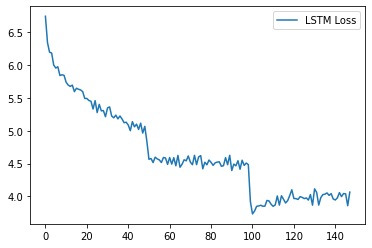

In [104]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.legend(['LSTM Loss'])

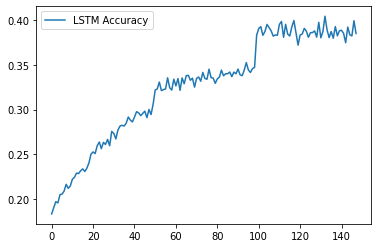

In [105]:
from matplotlib import pyplot as plt
plt.plot(accs)
plt.legend(['LSTM Accuracy'])

تابعی نوشته شده است برای پیش بینی مدل برای مصرع دوم. مصرع اول و دیکشنری را به مدل می دهیم و کلمات پیش بینی شده توسط مدل برگردانده می شود

In [168]:
def predict(firstHem, encoder, decoder, dictionary): 

        thisPair = tensorFromSentence(dictionary, firstHem)
        X = thisPair[0]
        y = thisPair[1]
        encoderHidden = encoder.initHidden()
        decodedWords = []

        encoderOutput = torch.zeros(maxLength, encoder.hiddenSize, device=device)
      
        for i in range(X.shape[0]):
            encoderOutput, encoderHidden = encoder(X[i], encoderHidden)

        decoderInput = torch.tensor([[SOS_token]], device=device)
        decoderHidden = encoderHidden

        for i in range(maxLength):
            decoderOutput, decoderHidden = decoder(decoderInput, decoderHidden)
            decodedWord = torch.argmax(decoderOutput)
            if decodedWord == torch.tensor([[EOS_token]], device=device):
                break
            else:    
                decodedWords.append(dictionary.index2word[decodedWord.item()])  

            decoderInput = torch.tensor([decodedWord]).to(device=device) 

        return decodedWords

این تابع صرفا کلمات بازگردانده شده توسط تابع قبل را به صورت جمله در می آورد

In [162]:
def HemGenerator(firstHem, encoder, decoder):
    secondHem = predict(firstHem, encoder, decoder, dictionary)
    out = ""
    for word in secondHem: 
      out = out + f" {word}"
    return out

یک نمونه از پیش بینی مدل ال اس تی ام

In [163]:
firstHem = pairs[101][0]
secondHem = HemGenerator(firstHem, encoderLSTM, decoderLSTM)
print(f"First Hem : {firstHem}")
print(f"Second Hem of LSTM : {secondHem}")

First Hem : چو هفتاد کشتی برو ساخته
Second Hem of LSTM :  راه که آفریننده سازد


In [182]:
firstHem = pairs[1125][0]
secondHem = HemGenerator(firstHem, encoderLSTM, decoderLSTM)
print(f"First Hem : {firstHem}")
print(f"Second Hem of LSTM : {secondHem}")

First Hem : ز کار آگهان آگهی یافتم
Second Hem of LSTM :  افتاد جان بسازید داشتم مهر آب


مدل جی آر یو دو طرفه که انکودر و دیکودر آن تعریف شده است

In [144]:
class EncoderGRUNet(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(EncoderGRUNet, self).__init__()
        self.hiddenSize = hiddenSize

        self.embedding = nn.Embedding(inputSize, hiddenSize)
        self.GRU = nn.GRU(self.hiddenSize, self.hiddenSize, bias = True, bidirectional = True)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, self.hiddenSize)
        output = embedded
        output, hidden = self.GRU(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(2, 1, self.hiddenSize, device=device)

In [149]:
class DecoderGRUNet(nn.Module):
    def __init__(self, hiddenSize, outputSize):
        super(DecoderGRUNet, self).__init__()
        self.hiddenSize = hiddenSize

        self.embedding = nn.Embedding(outputSize, hiddenSize)
        self.GRU = nn.GRU(hiddenSize, hiddenSize, bias = True, bidirectional = True)
        self.out = nn.Linear(2*hiddenSize, outputSize)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = nn.functional.relu(output)
        output, hidden = self.GRU(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    def initHidden(self):
        return torch.zeros(2, 1, self.hiddenSize, device=device)

مانند قبل با توابع قبلی مدل آموزش داده می شود با همان هایپرپارامترهای قبلی

In [152]:
hiddenSize = 256
batchSize = 32
epochs = 3
lr = 1e-3

encoderGRU = EncoderGRUNet(dictionary.n_words, hiddenSize).to(device)
decoderGRU = DecoderGRUNet(hiddenSize, dictionary.n_words).to(device)

losses, accs = trainLoop(trainingPairs, encoderGRU, decoderGRU, epochs, lr)

  0%|          | 0/49608 [00:00<?, ?it/s]<ipython-input-147-91c678333334>:36: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(encoderModel.parameters(), 1)
<ipython-input-147-91c678333334>:37: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(decoderModel.parameters(), 1)
  2%|▏         | 1006/49608 [00:25<20:55, 38.71it/s]

Loss : 6.895739208594574, Accuracy : 0.17964601769911503


  4%|▍         | 2007/49608 [00:51<20:36, 38.51it/s]

Loss : 6.442481172222209, Accuracy : 0.18640059127864006


  6%|▌         | 3005/49608 [01:16<19:34, 39.68it/s]

Loss : 6.2259492904913625, Accuracy : 0.19887290523505857


  8%|▊         | 4008/49608 [01:42<18:51, 40.29it/s]

Loss : 5.990019099580857, Accuracy : 0.21011615938832526


 10%|█         | 5008/49608 [02:07<18:23, 40.41it/s]

Loss : 5.930849206114913, Accuracy : 0.21377566200535555


 12%|█▏        | 6005/49608 [02:32<18:37, 39.03it/s]

Loss : 5.770615003499301, Accuracy : 0.2187778107386532


 14%|█▍        | 7006/49608 [02:58<17:55, 39.62it/s]

Loss : 5.7070077153081, Accuracy : 0.2329012069736254


 16%|█▌        | 8005/49608 [03:23<17:41, 39.19it/s]

Loss : 5.713582969278071, Accuracy : 0.23366983372921615


 18%|█▊        | 9007/49608 [03:48<17:28, 38.71it/s]

Loss : 5.534198191999632, Accuracy : 0.24213508274936632


 20%|██        | 10007/49608 [04:14<17:08, 38.51it/s]

Loss : 5.626038217041226, Accuracy : 0.2328159645232816


 22%|██▏       | 11005/49608 [04:39<17:07, 37.56it/s]

Loss : 5.481268915393181, Accuracy : 0.2439710016274597


 24%|██▍       | 12006/49608 [05:05<16:01, 39.11it/s]

Loss : 5.286014644902856, Accuracy : 0.2598844957796535


 26%|██▌       | 13007/49608 [05:30<15:33, 39.22it/s]

Loss : 5.465977864017285, Accuracy : 0.25100014817009925


 28%|██▊       | 14007/49608 [05:55<14:56, 39.69it/s]

Loss : 5.324936383355892, Accuracy : 0.26088882326886165


 30%|███       | 15007/49608 [06:21<14:06, 40.87it/s]

Loss : 5.272581601088702, Accuracy : 0.26180956611876205


 32%|███▏      | 16005/49608 [06:46<14:01, 39.93it/s]

Loss : 5.216432957164948, Accuracy : 0.26628096721554667


 34%|███▍      | 17007/49608 [07:11<13:55, 39.00it/s]

Loss : 5.325524288420662, Accuracy : 0.2662347224267413


 36%|███▋      | 18003/49608 [07:37<13:07, 40.12it/s]

Loss : 5.109844902265153, Accuracy : 0.27359050445103855


 38%|███▊      | 19007/49608 [08:02<13:26, 37.93it/s]

Loss : 5.1638180952232275, Accuracy : 0.27140740740740743


 40%|████      | 20008/49608 [08:28<12:23, 39.81it/s]

Loss : 5.17952451266413, Accuracy : 0.27270029673590507


 42%|████▏     | 21006/49608 [08:53<12:19, 38.66it/s]

Loss : 5.11842449970662, Accuracy : 0.2813424009461857


 44%|████▍     | 22005/49608 [09:18<11:55, 38.58it/s]

Loss : 5.097676071257248, Accuracy : 0.2773420156874353


 46%|████▋     | 23007/49608 [09:44<11:35, 38.24it/s]

Loss : 5.0860235965153855, Accuracy : 0.2867647058823529


 48%|████▊     | 24006/49608 [10:09<10:45, 39.67it/s]

Loss : 5.078566117615863, Accuracy : 0.28109854604200324


 50%|█████     | 25005/49608 [10:34<10:24, 39.40it/s]

Loss : 5.0789539953864145, Accuracy : 0.28749443702714733


 52%|█████▏    | 26004/49608 [11:00<10:11, 38.59it/s]

Loss : 5.0708796528639635, Accuracy : 0.28891526932779343


 54%|█████▍    | 27007/49608 [11:25<09:35, 39.29it/s]

Loss : 4.934362778199651, Accuracy : 0.298938679245283


 56%|█████▋    | 28004/49608 [11:51<08:58, 40.09it/s]

Loss : 4.977492135325829, Accuracy : 0.29564960047351285


 58%|█████▊    | 29005/49608 [12:16<08:52, 38.66it/s]

Loss : 4.962720532766229, Accuracy : 0.2979707549985079


 60%|██████    | 30004/49608 [12:41<08:21, 39.08it/s]

Loss : 4.9248379282483565, Accuracy : 0.2990348923533779


 63%|██████▎   | 31006/49608 [13:07<07:43, 40.12it/s]

Loss : 4.990866166057468, Accuracy : 0.3010800414262465


 65%|██████▍   | 32007/49608 [13:32<07:35, 38.60it/s]

Loss : 4.97035168464015, Accuracy : 0.3017601431980907


 67%|██████▋   | 33008/49608 [13:57<06:52, 40.29it/s]

Loss : 5.01666551936977, Accuracy : 0.2949533816782596


 69%|██████▊   | 34006/49608 [14:23<06:38, 39.14it/s]

Loss : 4.918076267869003, Accuracy : 0.30707610146862485


 71%|███████   | 35005/49608 [14:48<06:11, 39.33it/s]

Loss : 4.788907038367103, Accuracy : 0.31737061273051753


 73%|███████▎  | 36004/49608 [15:13<05:43, 39.57it/s]

Loss : 4.786461806626074, Accuracy : 0.3160730320263394


 75%|███████▍  | 37005/49608 [15:39<05:26, 38.54it/s]

Loss : 4.90208863352703, Accuracy : 0.30172919109026963


 77%|███████▋  | 38004/49608 [16:04<04:48, 40.28it/s]

Loss : 4.886941146457384, Accuracy : 0.30704099821746883


 79%|███████▊  | 39007/49608 [16:30<04:33, 38.76it/s]

Loss : 4.85492725019388, Accuracy : 0.3104874446085672


 81%|████████  | 40006/49608 [16:55<03:59, 40.08it/s]

Loss : 4.902148271326311, Accuracy : 0.30856291883842146


 83%|████████▎ | 41005/49608 [17:20<03:43, 38.54it/s]

Loss : 4.866723855652383, Accuracy : 0.311613475177305


 85%|████████▍ | 42003/49608 [17:46<03:30, 36.15it/s]

Loss : 4.896055591243631, Accuracy : 0.31141512209473377


 87%|████████▋ | 43007/49608 [18:11<02:47, 39.47it/s]

Loss : 4.766469398256808, Accuracy : 0.3251047277079593


 89%|████████▊ | 44006/49608 [18:37<02:24, 38.65it/s]

Loss : 4.866773381709722, Accuracy : 0.30654454129118036


 91%|█████████ | 45006/49608 [19:02<01:58, 38.74it/s]

Loss : 4.811443951369467, Accuracy : 0.3106680553489064


 93%|█████████▎| 46005/49608 [19:28<01:30, 39.85it/s]

Loss : 4.841500414460434, Accuracy : 0.32416444838805086


 95%|█████████▍| 47007/49608 [19:53<01:04, 40.51it/s]

Loss : 4.720423625573426, Accuracy : 0.32700859768751855


 97%|█████████▋| 48007/49608 [20:19<00:40, 39.05it/s]

Loss : 4.837013509317598, Accuracy : 0.3188340807174888


 99%|█████████▉| 49004/49608 [20:44<00:15, 39.32it/s]

Loss : 4.669009455168921, Accuracy : 0.31799287410926363


  1%|          | 396/49608 [00:10<27:24, 29.93it/s]

Loss : 4.365299018366923, Accuracy : 0.34503009837028337


  3%|▎         | 1400/49608 [00:37<20:09, 39.85it/s]

Loss : 3.826077319702158, Accuracy : 0.39222404290183227


  5%|▍         | 2398/49608 [01:05<19:59, 39.37it/s]

Loss : 3.814028222687117, Accuracy : 0.39468606204542084


  7%|▋         | 3400/49608 [01:31<19:39, 39.16it/s]

Loss : 3.958891273311924, Accuracy : 0.37468202902887926


  9%|▉         | 4397/49608 [01:59<21:39, 34.79it/s]

Loss : 3.821701242672548, Accuracy : 0.386094674556213


 11%|█         | 5399/49608 [02:25<18:31, 39.79it/s]

Loss : 3.888601998597683, Accuracy : 0.3811932748102961


 13%|█▎        | 6396/49608 [02:51<18:28, 39.00it/s]

Loss : 3.9345104489795792, Accuracy : 0.3828090385467435


 15%|█▍        | 7396/49608 [03:16<18:34, 37.88it/s]

Loss : 3.9770606639185906, Accuracy : 0.3789520558111919


 17%|█▋        | 8398/49608 [03:43<17:19, 39.64it/s]

Loss : 3.9643286264135775, Accuracy : 0.3796665191087502


 19%|█▉        | 9395/49608 [04:12<23:51, 28.09it/s]

Loss : 4.063413515884156, Accuracy : 0.36811637227252486


 21%|██        | 10397/49608 [04:38<16:29, 39.64it/s]

Loss : 4.078548497785275, Accuracy : 0.37254031661488385


 23%|██▎       | 11397/49608 [05:04<16:31, 38.53it/s]

Loss : 3.99353640464766, Accuracy : 0.3777516877017904


 25%|██▍       | 12399/49608 [05:30<15:31, 39.95it/s]

Loss : 4.113801558319747, Accuracy : 0.3711309523809524


 27%|██▋       | 13397/49608 [05:55<15:07, 39.89it/s]

Loss : 4.194888499939032, Accuracy : 0.3576523031203566


 29%|██▉       | 14398/49608 [06:22<15:13, 38.55it/s]

Loss : 4.081207777974729, Accuracy : 0.3704304245283019


 31%|███       | 15397/49608 [06:48<14:47, 38.56it/s]

Loss : 4.125530100591126, Accuracy : 0.37967674348997305


 33%|███▎      | 16400/49608 [07:18<14:01, 39.47it/s]

Loss : 4.053307103647161, Accuracy : 0.3782666469806585


 35%|███▌      | 17398/49608 [07:44<14:11, 37.83it/s]

Loss : 3.99348721539434, Accuracy : 0.37590007347538573


 37%|███▋      | 18397/49608 [08:10<13:18, 39.10it/s]

Loss : 4.19289466803766, Accuracy : 0.36959098992294015


 39%|███▉      | 19396/49608 [08:36<13:25, 37.51it/s]

Loss : 4.1936530211367735, Accuracy : 0.3702990820254664


 41%|████      | 20397/49608 [09:03<12:36, 38.61it/s]

Loss : 4.221412505108113, Accuracy : 0.37448194197750145


 43%|████▎     | 21396/49608 [09:30<12:39, 37.15it/s]

Loss : 4.129053265985327, Accuracy : 0.374496644295302


 45%|████▌     | 22397/49608 [09:59<13:32, 33.49it/s]

Loss : 4.134324215670325, Accuracy : 0.36194140278188813


 47%|████▋     | 23398/49608 [10:26<12:09, 35.93it/s]

Loss : 4.248978033347809, Accuracy : 0.3715766099185788


 49%|████▉     | 24400/49608 [10:55<10:36, 39.58it/s]

Loss : 4.12671867931254, Accuracy : 0.37927461139896373


 51%|█████     | 25397/49608 [11:23<11:23, 35.40it/s]

Loss : 4.1662512536251235, Accuracy : 0.37896618501415164


 53%|█████▎    | 26395/49608 [11:50<11:57, 32.34it/s]

Loss : 4.113672904936816, Accuracy : 0.37572254335260113


 55%|█████▌    | 27395/49608 [12:18<12:18, 30.08it/s]

Loss : 4.180741474035713, Accuracy : 0.37579806978470676


 57%|█████▋    | 28399/49608 [12:45<09:12, 38.35it/s]

Loss : 4.204066466273064, Accuracy : 0.373341197286936


 59%|█████▉    | 29395/49608 [13:12<10:28, 32.17it/s]

Loss : 4.111272123029698, Accuracy : 0.37364594153435227


 61%|██████▏   | 30397/49608 [13:39<08:53, 36.01it/s]

Loss : 4.312774256870312, Accuracy : 0.34960908688597137


 63%|██████▎   | 31396/49608 [14:10<08:11, 37.04it/s]

Loss : 4.247196431620045, Accuracy : 0.37014616861065996


 65%|██████▌   | 32397/49608 [14:36<07:16, 39.43it/s]

Loss : 4.089044986796086, Accuracy : 0.37516590473381506


 67%|██████▋   | 33399/49608 [15:01<06:44, 40.09it/s]

Loss : 4.150699150088524, Accuracy : 0.37381093935790727


 69%|██████▉   | 34397/49608 [15:27<06:28, 39.19it/s]

Loss : 4.085211290510731, Accuracy : 0.38340507644352084


 71%|███████▏  | 35396/49608 [15:53<05:44, 41.29it/s]

Loss : 4.0557937778920605, Accuracy : 0.3804748562158974


 73%|███████▎  | 36400/49608 [16:20<05:27, 40.28it/s]

Loss : 4.152738586206599, Accuracy : 0.37184437184437186


 75%|███████▌  | 37399/49608 [16:49<05:11, 39.24it/s]

Loss : 4.128134501238765, Accuracy : 0.3724911452184179


 77%|███████▋  | 38399/49608 [17:17<04:46, 39.07it/s]

Loss : 4.107082627100949, Accuracy : 0.3742231429416987


 79%|███████▉  | 39396/49608 [17:43<04:16, 39.87it/s]

Loss : 4.143640227916241, Accuracy : 0.37430753106752507


 81%|████████▏ | 40396/49608 [18:08<03:48, 40.30it/s]

Loss : 4.058914608226693, Accuracy : 0.38185591461606877


 83%|████████▎ | 41397/49608 [18:35<03:32, 38.58it/s]

Loss : 4.076766752157377, Accuracy : 0.37746478873239436


 85%|████████▌ | 42399/49608 [19:00<03:07, 38.47it/s]

Loss : 4.146867778428675, Accuracy : 0.37702241353718274


 87%|████████▋ | 43400/49608 [19:26<02:37, 39.53it/s]

Loss : 4.10721854095721, Accuracy : 0.3798749627865436


 89%|████████▉ | 44396/49608 [19:51<02:09, 40.10it/s]

Loss : 4.07873421631005, Accuracy : 0.37451908848771825


 92%|█████████▏| 45398/49608 [20:17<01:44, 40.22it/s]

Loss : 4.0387587381533425, Accuracy : 0.3925399644760213


 94%|█████████▎| 46399/49608 [20:42<01:21, 39.18it/s]

Loss : 4.11729692845662, Accuracy : 0.3812212152726192


 96%|█████████▌| 47398/49608 [21:08<00:56, 38.90it/s]

Loss : 3.9656954379120277, Accuracy : 0.3835214777891805


 98%|█████████▊| 48397/49608 [21:34<00:30, 39.32it/s]

Loss : 4.209944643061863, Accuracy : 0.3682256867112101


100%|█████████▉| 49397/49608 [21:59<00:05, 39.40it/s]

Loss : 3.943857803194326, Accuracy : 0.39165683962264153


  2%|▏         | 789/49608 [00:20<20:15, 40.16it/s]

Loss : 3.3136874537991843, Accuracy : 0.43585574933490984


  4%|▎         | 1792/49608 [00:45<20:44, 38.43it/s]

Loss : 2.967550221539271, Accuracy : 0.4655684179281686


  6%|▌         | 2792/49608 [01:11<19:44, 39.54it/s]

Loss : 3.102631144922008, Accuracy : 0.4479671216791428


  8%|▊         | 3790/49608 [01:36<19:12, 39.74it/s]

Loss : 3.1157457944457367, Accuracy : 0.44717261904761907


 10%|▉         | 4788/49608 [02:02<18:29, 40.40it/s]

Loss : 3.239649449904248, Accuracy : 0.43758429491982614


 12%|█▏        | 5791/49608 [02:28<18:24, 39.68it/s]

Loss : 3.23276822287245, Accuracy : 0.4338530066815145


 14%|█▎        | 6788/49608 [02:53<17:41, 40.34it/s]

Loss : 3.2070910990867123, Accuracy : 0.4406679473917541


 16%|█▌        | 7790/49608 [03:19<18:29, 37.70it/s]

Loss : 3.3329285605558447, Accuracy : 0.43209505188750186


 18%|█▊        | 8787/49608 [03:45<18:43, 36.32it/s]

Loss : 3.2383968298012755, Accuracy : 0.4435245416913069


 20%|█▉        | 9788/49608 [04:11<16:58, 39.09it/s]

Loss : 3.3116908247848733, Accuracy : 0.436747435706853


 22%|██▏       | 10791/49608 [04:37<17:11, 37.64it/s]

Loss : 3.312095337062799, Accuracy : 0.437776467118844


 24%|██▍       | 11792/49608 [05:03<15:35, 40.43it/s]

Loss : 3.2693347778098505, Accuracy : 0.4495835812016657


 26%|██▌       | 12790/49608 [05:28<15:35, 39.34it/s]

Loss : 3.414359923057034, Accuracy : 0.42812868949232585


 28%|██▊       | 13791/49608 [05:54<15:43, 37.98it/s]

Loss : 3.290103331330487, Accuracy : 0.44905320108205593


 30%|██▉       | 14792/49608 [06:20<14:38, 39.63it/s]

Loss : 3.4449055962860817, Accuracy : 0.4276570407859482


 32%|███▏      | 15788/49608 [06:45<14:40, 38.39it/s]

Loss : 3.3622582011136504, Accuracy : 0.43693493404476064


 34%|███▍      | 16788/49608 [07:11<13:40, 39.98it/s]

Loss : 3.4647743984985033, Accuracy : 0.4290575528924397


 36%|███▌      | 17788/49608 [07:37<13:50, 38.31it/s]

Loss : 3.405980470270727, Accuracy : 0.42774394772018415


 38%|███▊      | 18789/49608 [08:02<13:20, 38.51it/s]

Loss : 3.448277988067641, Accuracy : 0.4297960390186225


 40%|███▉      | 19791/49608 [08:28<12:24, 40.02it/s]

Loss : 3.457840650517837, Accuracy : 0.42345132743362834


 42%|████▏     | 20791/49608 [08:54<12:29, 38.46it/s]

Loss : 3.5129793011583432, Accuracy : 0.4180857310628303


 44%|████▍     | 21792/49608 [09:20<11:40, 39.72it/s]

Loss : 3.5211641938090663, Accuracy : 0.43327428402716267


 46%|████▌     | 22791/49608 [09:45<11:28, 38.96it/s]

Loss : 3.545293814159337, Accuracy : 0.41864256075874334


 48%|████▊     | 23790/49608 [10:11<11:06, 38.75it/s]

Loss : 3.442242813026722, Accuracy : 0.4371941272430669


 50%|████▉     | 24789/49608 [10:37<10:47, 38.32it/s]

Loss : 3.5449284101235663, Accuracy : 0.42320869953820944


 52%|█████▏    | 25791/49608 [11:03<10:49, 36.67it/s]

Loss : 3.585925726050113, Accuracy : 0.42181607194662024


 54%|█████▍    | 26790/49608 [11:29<09:26, 40.27it/s]

Loss : 3.573007551400041, Accuracy : 0.4224606791121564


 56%|█████▌    | 27788/49608 [11:55<09:48, 37.09it/s]

Loss : 3.44679687532349, Accuracy : 0.43565822597364134


 58%|█████▊    | 28791/49608 [12:21<08:39, 40.05it/s]

Loss : 3.4468568437527742, Accuracy : 0.435292349316098


 60%|██████    | 29788/49608 [12:46<08:14, 40.06it/s]

Loss : 3.6148499264934157, Accuracy : 0.41493467933491684


 62%|██████▏   | 30792/49608 [13:12<07:45, 40.42it/s]

Loss : 3.491167618070134, Accuracy : 0.43600771170102326


 64%|██████▍   | 31788/49608 [13:37<07:47, 38.14it/s]

Loss : 3.4825854652817214, Accuracy : 0.42949101796407185


 66%|██████▌   | 32788/49608 [14:03<07:17, 38.42it/s]

Loss : 3.6355088067387813, Accuracy : 0.41819526627218934


 68%|██████▊   | 33788/49608 [14:29<06:49, 38.61it/s]

Loss : 3.597359678275433, Accuracy : 0.419773095623987


 70%|███████   | 34789/49608 [14:54<06:23, 38.65it/s]

Loss : 3.5500271694938785, Accuracy : 0.4188235294117647


 72%|███████▏  | 35789/49608 [15:20<05:50, 39.45it/s]

Loss : 3.535235060441348, Accuracy : 0.42876047640052933


 74%|███████▍  | 36788/49608 [15:45<05:29, 38.91it/s]

Loss : 3.5701304542753687, Accuracy : 0.4359164320640095


 76%|███████▌  | 37790/49608 [16:12<04:55, 39.96it/s]

Loss : 3.6177989978734906, Accuracy : 0.4264727704407182


 78%|███████▊  | 38789/49608 [16:42<04:44, 38.09it/s]

Loss : 3.596207440891037, Accuracy : 0.4164061336906357


 80%|████████  | 39788/49608 [17:11<04:31, 36.11it/s]

Loss : 3.390247273583625, Accuracy : 0.43118184497494844


 82%|████████▏ | 40788/49608 [17:39<04:01, 36.56it/s]

Loss : 3.545517122829168, Accuracy : 0.42829658132307236


 84%|████████▍ | 41788/49608 [18:07<03:18, 39.41it/s]

Loss : 3.457950430851877, Accuracy : 0.4394810555801268


 86%|████████▋ | 42792/49608 [18:33<02:52, 39.60it/s]

Loss : 3.6759809454650196, Accuracy : 0.42015180830480725


 88%|████████▊ | 43790/49608 [18:59<02:33, 37.98it/s]

Loss : 3.522434355107187, Accuracy : 0.4295932051855163


 90%|█████████ | 44785/49608 [19:25<02:20, 34.42it/s]

Loss : 3.5733273836038917, Accuracy : 0.43141330166270786


 92%|█████████▏| 45790/49608 [19:51<01:51, 34.17it/s]

Loss : 3.589665134547791, Accuracy : 0.41697254441344883


 94%|█████████▍| 46792/49608 [20:17<01:09, 40.25it/s]

Loss : 3.546551760908263, Accuracy : 0.4265444871415903


 96%|█████████▋| 47791/49608 [20:43<00:45, 39.63it/s]

Loss : 3.6129183556585387, Accuracy : 0.42287669195299715


 98%|█████████▊| 48790/49608 [21:11<00:20, 39.63it/s]

Loss : 3.550947966525866, Accuracy : 0.4317102137767221


100%|██████████| 49608/49608 [21:32<00:00, 38.37it/s]


در این حالت نیز خسارت نزولی و دقت صعودی است و شبکه آموزش داده می شود. دقت کنید که با هایپرپارامترهای برابر، دقت این مدل از مدل قبلی یعنی ال اس تی ام خسارت کمتر و دقتر بهتر دارد و عملکرد بهتری دارد

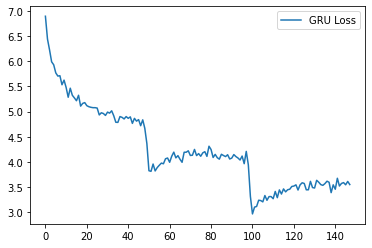

In [153]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.legend(['GRU Loss'])

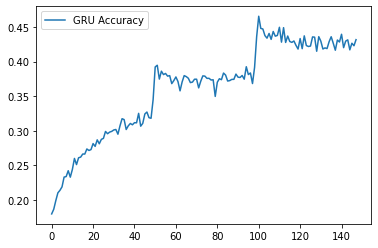

In [154]:
from matplotlib import pyplot as plt
plt.plot(accs)
plt.legend(['GRU Accuracy'])

چند پیش بینی از شبکه جی آر یو

In [171]:
firstHem = pairs[98][0]
secondHem = HemGenerator(firstHem, encoderGRU, decoderGRU)
print(f"First Hem : {firstHem}")
print(f"Second Hem of GRU : {secondHem}")

First Hem : نبی آفتاب و صحابان چو ماه
Second Hem of GRU :  مهر رخساره دلست نگارندهٔ ببسته نگارندهٔ هست


In [190]:
firstHem = pairs[1][0]
secondHem = HemGenerator(firstHem, encoderGRU, decoderGRU)
print(f"First Hem : {firstHem}")
print(f"Second Hem of GRU : {secondHem}")

First Hem : خداوند نام و خداوند جای
Second Hem of GRU :  نام دستگیر جان نام باد
